# Lab 1: Loading and plotting geophysical data

In this lab, we'll use some common Python tools to load and plot some geophysical datasets seen in [Lecture 1](https://www.leouieda.com/envs398/slides/1-plate-tectonics/). We will write the code together and there are some questions for you to answer regarding the datasets.

We'll cover 2 data types routinely used in scientific Python:

* `numpy.array`: for arrays (matrices, vectors, etc)
* `xarray.Dataset` and `xarray.DataArray`: for grids

## General instructions

This is a [Jupyter notebook](https://jupyter.org/) running in [Jupyter Lab](https://jupyterlab.readthedocs.io/en/stable/). The notebook is a programming environment that mixes code (the parts with `[1]: ` or similar next to them) and formatted text/images/equations with [Markdown](https://www.markdownguide.org/basic-syntax) (like this part right here).

Quick start guide:

* **Edit** any cell (blocks of code or text) by double clicking on it.
* **Execute** a code or Markdown cell by typing `Shift + Enter` after selecting it.
* The current active cell is the one with a **blue bar next to it**.
* You can run cells **in any order** as long as the code sequence makes sense (it's best to go top-to-bottom, though).
* To copy any file to the current directory, drag and drop it to the file browser on the left side.
* Notebook files have the extension `.ipynb`.

## Import things

First thing to do is load the Python libraries that we'll be using. The power of the many available libraries is what makes Python so powerful. We'll group all our imports here at the top to make it easier to see what we're using.

In [1]:
# To open compressed files. Part of the Python standard library. 
import gzip
import bz2
# For making plots and figures
import matplotlib.pyplot as plt
# The base of the entire scientific Python stack
import numpy as np
# For working with grids
import xarray as xr
# Nice colormaps for geoscience
import cmocean
# For plotting with projections
import cartopy.crs as ccrs

## Global seismicity catalog

Now we'll move on to the Global CMT catalog of earthquake hypocenters.

1. Download the "gzip compressed" version of the catalog from https://www.globalcmt.org/CMTfiles.html
2. Drag it to the `data` folder.

This is one is trickier because there is no clear structure to the file. So tools like `pandas` and `numpy` won't be able to load it. We'll have to do this ourselves then...

In [2]:
# Use the gzip library to open the compressed file directly, like magic!
with gzip.open("../data/jan76_dec17.ndk.gz", "rt") as quake_file:
    # Start off with an empty list and we'll populate it with quakes one at a time
    quakes = []
    # Read and iterate over the lines of the file one by one.
    # Use enumerate to get the line number as well.
    for line_number, line in enumerate(quake_file):
        # The data we want (location and depth) are only in every 5th line
        if line_number % 5 == 0:
            # The line looks like this:
            #   MLI  1976/01/01 01:29:39.6 -28.61 -177.64  59.0 6.2 0.0 KERMADEC ISLANDS REGION 
            # Split the line along spaces
            parts = line.split()
            # Unpack the location and depth into variables
            latitude, longitude, depth = parts[3:6]
            # Add the 3 variables to the quakes list
            quakes.append([latitude, longitude, depth])

To make the data easier to use, we can convert it to a `numpy.array`. This is the basic datatype used for most scientific Python packages ad forms the basis for the entire stack.

In [3]:
quakes = np.array(quakes, dtype="float32")
print(quakes)

[[ -28.61 -177.64   59.  ]
 [ -13.29  -74.9    95.  ]
 [  51.6   159.33   33.  ]
 ...
 [  -8.12   68.06   10.  ]
 [ -53.03 -118.35   10.  ]
 [  17.86  145.89  156.6 ]]


Use `cartopy` to plot the location and depth of earthquakes.

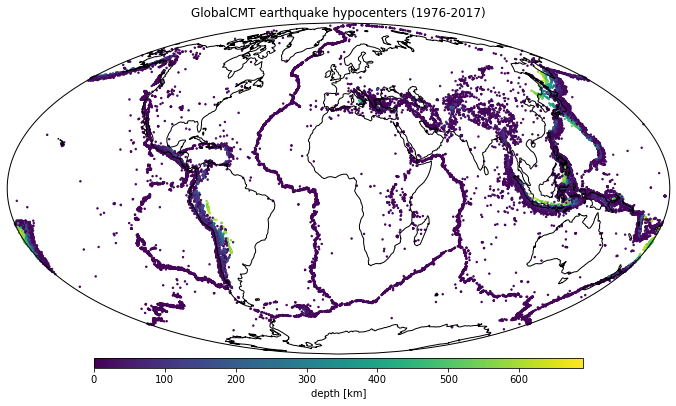

In [4]:
plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.Mollweide())
ax.set_title("GlobalCMT earthquake hypocenters (1976-2017)")
# Scatter takes the point locations, size, and color
tmp = ax.scatter(quakes[:, 1], quakes[:, 0], s=2, c=quakes[:, 2], transform=ccrs.PlateCarree())
# Add a color bar related to the scatter we just plotted
plt.colorbar(tmp, label="depth [km]", orientation="horizontal", aspect=50, pad=0.01, shrink=0.7)
ax.coastlines()
plt.tight_layout()
plt.show()

## Age of the oceanic crust

The age of the oceanic crust dataset is a grid. The typical format many people use to store grids is called [NetCDF](https://en.wikipedia.org/wiki/NetCDF) (usually with extension `.nc` or `.grd`). To handle this type of dataset, we will use the `xarray` library.

1. Download the "Crustal Age" grid version 3 at 6 arc-minute resolution in NetCDF format (`age.3.6.nc.bz2`) from NOAA: https://www.ngdc.noaa.gov/mgg/ocean_age/ocean_age_2008.html
2. Drag it to the `data` folder.
3. Use `xarray.open_dataarray` to load it with `bz2` to decompress the file first.

In [5]:
with bz2.open("../data/age.3.6.nc.bz2") as grid_file:
    age = xr.open_dataarray(grid_file)
age

<xarray.DataArray 'z' (y: 1801, x: 3601)>
[6485401 values with dtype=float32]
Coordinates:
  * x        (x) float32 -180.0 -179.9 -179.8 -179.7 ... 179.7 179.8 179.9 180.0
  * y        (y) float32 -90.0 -89.9 -89.8 -89.7 -89.6 ... 89.7 89.8 89.9 90.0
Attributes:
    long_name:     z
    actual_range:  [    0. 28000.]

Plot the grid using `pcolormesh` from matplotlib.

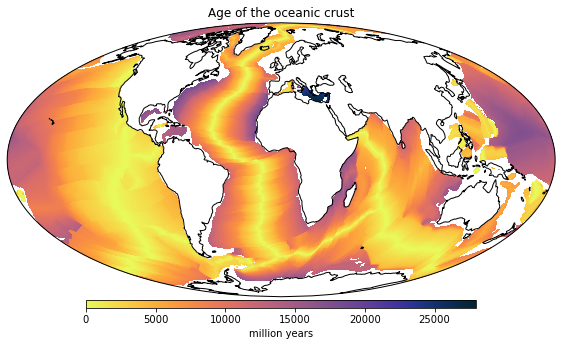

In [6]:
plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.Mollweide())
ax.set_title("Age of the oceanic crust")
# Plot the grid using a nice color map from cmocean
tmp = ax.pcolormesh(
    age.x, age.y, age, transform=ccrs.PlateCarree(), 
    cmap=cmocean.cm.thermal_r,
)
plt.colorbar(tmp, label="million years", orientation="horizontal", aspect=50, pad=0.01, shrink=0.7)
ax.coastlines()
plt.show()

**Do those values look correct?** Read the `readme.txt` file on the NOAA server: https://www.ngdc.noaa.gov/mgg/ocean_age/data/2008/grids/age/readme.txt (If a file is called "readme", always read it).

In [7]:
age = age / 100

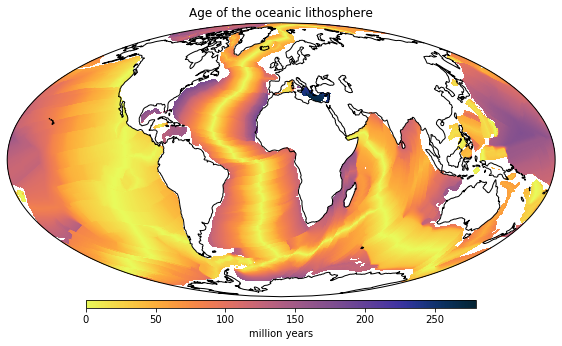

In [8]:
plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.Mollweide())
ax.set_title("Age of the oceanic lithosphere")
tmp = ax.pcolormesh(
    age.x, age.y, age, transform=ccrs.PlateCarree(), 
    cmap=cmocean.cm.thermal_r,
)
plt.colorbar(tmp, label="million years", orientation="horizontal", aspect=50, pad=0.01, shrink=0.7)
ax.coastlines()
plt.show()

## Questions

Discuss the following in small groups:

1. Does sea floor spreading happen at the same rate everywhere?
2. Does the maximum earthquake depth indicate the maximum depth of subduction?
3. Which aspect of loading data in Python did you find most difficult?
4. What could be done to make it easier?